In [1]:
from pathlib import Path
from LHC_FillingPattern import LHCFillingPattern 
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import pandas as pd
from matplotlib.lines import Line2D
from scipy.integrate import cumtrapz 

In [2]:
DATADIR = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/md_data/MD15363""/HX:FILLN=10739/")
df = pd.read_parquet(DATADIR)   
#print(df.columns.tolist())
#fbmodes = pd.read_parquet(DATADIR)

In [ ]:
CMS_PV = 'CMS:BUNCH_LUMI_INST'
BETASTAR_PV    = "HX:BETASTAR_IP1" #'HX:BETASTAR_IP1', HX:BETASTAR_IP2', 'HX:BETASTAR_IP5', 'HX:BETASTAR_IP8'
XING_PV = 'LhcStateTracker:LHCBEAM:IP1-XING-H-MURAD:value'

bids = [20, 500, 1250, 1800,2874]  

### First Window

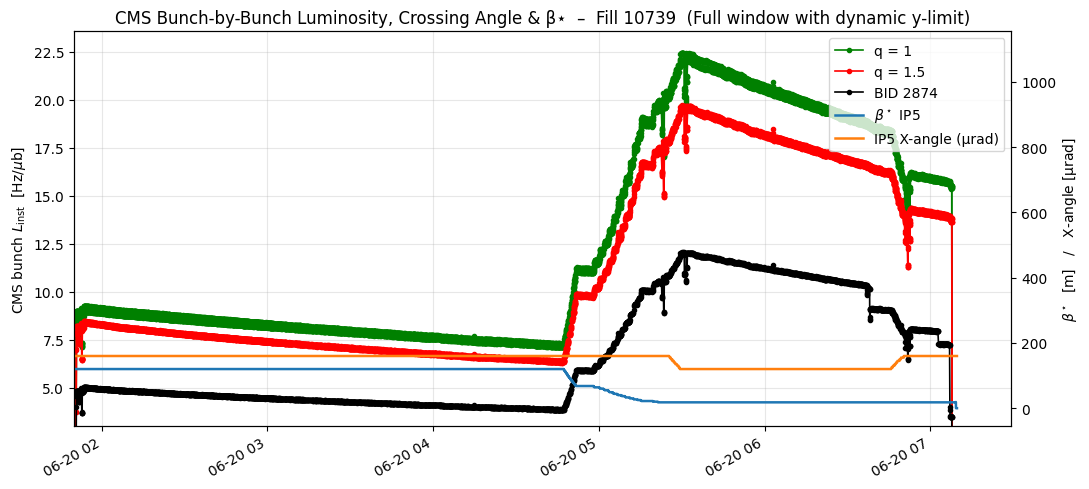

In [6]:
BUNCH_GROUPS_CMS = {
    "q = 1"  : ([20, 500],    "green"),
    "q = 1.5": ([1250, 1800], "red"),
}
SOLO_BID_CMS       = 2874  # plotted in black
DYNAMIC_YLIM_CMS   = True  # Enable dynamic y-axis scaling
TITLE_SUFFIX_CMS   = "Full window with dynamic y-limit"

# --- Load data ---
def load_bunch_array_cms(pv_name: str, bid_list):
    raw_cms = (
        dd.read_parquet(DATADIR, columns=[pv_name])
          .dropna()
          .compute()
    )
    raw_cms.index = pd.to_datetime(raw_cms.index, unit="ns")
    raw_cms.sort_index(inplace=True)
    mat_cms    = np.stack(raw_cms[pv_name].values)  # nTimes × 3564
    sliced_cms = mat_cms[:, bid_list]
    return pd.DataFrame(
        sliced_cms,
        index   = raw_cms.index,
        columns = [f"B{bid}" for bid in bid_list]
    )

all_bids_cms = [
    *BUNCH_GROUPS_CMS["q = 1"][0],
    *BUNCH_GROUPS_CMS["q = 1.5"][0],
    SOLO_BID_CMS
]
df_cms = load_bunch_array_cms(CMS_PV, all_bids_cms)

df_beta_cms = (
    dd.read_parquet(DATADIR, columns=[BETASTAR_PV])
      .dropna()
      .compute()
)
df_beta_cms.index = pd.to_datetime(df_beta_cms.index, unit="ns")
df_beta_cms.sort_index(inplace=True)

df_xing_cms = (
    dd.read_parquet(DATADIR, columns=[XING_PV])
      .dropna()
      .compute()
)
df_xing_cms.index = pd.to_datetime(df_xing_cms.index, unit="ns")
df_xing_cms.sort_index(inplace=True)

# --- Synchronize time range across datasets ---
t0_cms = max(df_cms.index.min(), df_beta_cms.index.min(), df_xing_cms.index.min())
t1_cms = min(df_cms.index.max(), df_beta_cms.index.max(), df_xing_cms.index.max())
df_cms      = df_cms.loc[t0_cms:t1_cms]
df_beta_cms = df_beta_cms.loc[t0_cms:t1_cms]
df_xing_cms = df_xing_cms.loc[t0_cms:t1_cms]

# --- Plotting ---
fig_cms, ax_lumi_cms = plt.subplots(figsize=(11, 5))

# CMS bunch-by-bunch luminosity
for lbl_cms, (bids_cms, colour_cms) in BUNCH_GROUPS_CMS.items():
    df_cms[[f"B{b}" for b in bids_cms]].plot(
        ax         = ax_lumi_cms,
        color      = colour_cms,
        linewidth  = 1.2,
        marker     = ".",
        legend     = False
    )
ax_lumi_cms.plot(
    df_cms.index,
    df_cms[f"B{SOLO_BID_CMS}"],
    color     = "black",
    linewidth = 1.2,
    marker    = ".",
    label     = "_nolegend_"
)
ax_lumi_cms.set_ylabel(r"CMS bunch $L_{\rm inst}$  [Hz/$\mu$b]")

# --- Dynamic y-limit ---
if DYNAMIC_YLIM_CMS:
    y_max_cms = df_cms.max().max()
    ax_lumi_cms.set_ylim(3, y_max_cms * 1.05)
else:
    ax_lumi_cms.set_ylim(3, 9.5)

# Title
ax_lumi_cms.set_title(
    f"CMS Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  ({TITLE_SUFFIX_CMS})"
)
ax_lumi_cms.grid(alpha=0.3)

# Right axis: β⋆ and X-angle at IP5
ax_r_cms = ax_lumi_cms.twinx()
df_beta_cms[BETASTAR_PV].plot(
    ax        = ax_r_cms,
    color     = "tab:blue",
    linewidth = 1.8,
    label     = r"$\beta^\star$ IP5"
)
df_xing_cms[XING_PV].plot(
    ax        = ax_r_cms,
    color     = "tab:orange",
    linewidth = 1.8,
    label     = r"IP5 X-angle (µrad)"
)
ax_r_cms.set_ylabel(r"$\beta^\star$  [m]   /   X-angle [µrad]")

# Legend
custom_handles_cms = [
    Line2D([0], [0], color="green",  marker=".", linestyle="-", linewidth=1.2, label="q = 1"),
    Line2D([0], [0], color="red",    marker=".", linestyle="-", linewidth=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black",  marker=".", linestyle="-", linewidth=1.2, label=f"BID {SOLO_BID_CMS}"),
    ax_r_cms.lines[0],
    ax_r_cms.lines[1],
]
ax_lumi_cms.legend(handles=custom_handles_cms, loc="upper right")

# Optional x-range zoom
ax_lumi_cms.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()


CMS: β⋆ starts changing (after 04:00) at: 2025-06-20 04:47:13.295738525


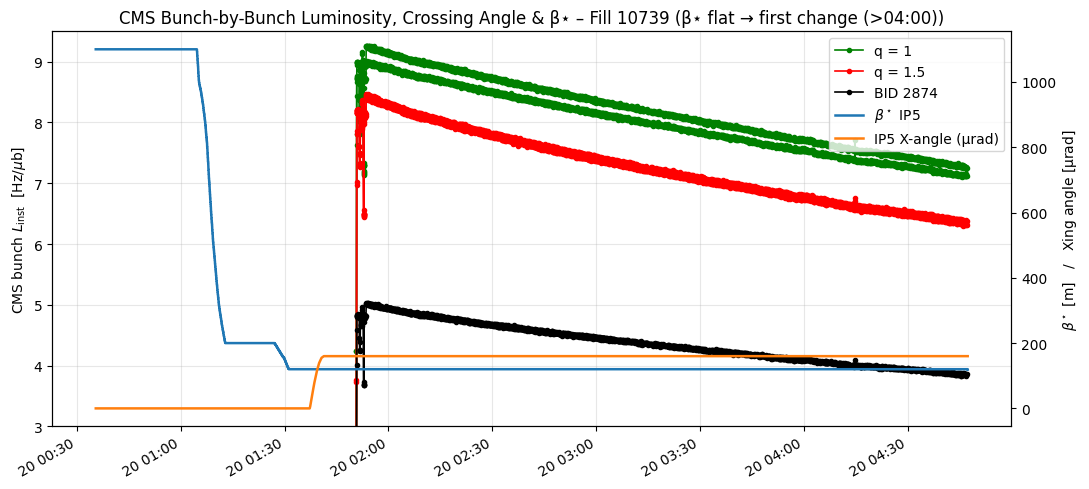

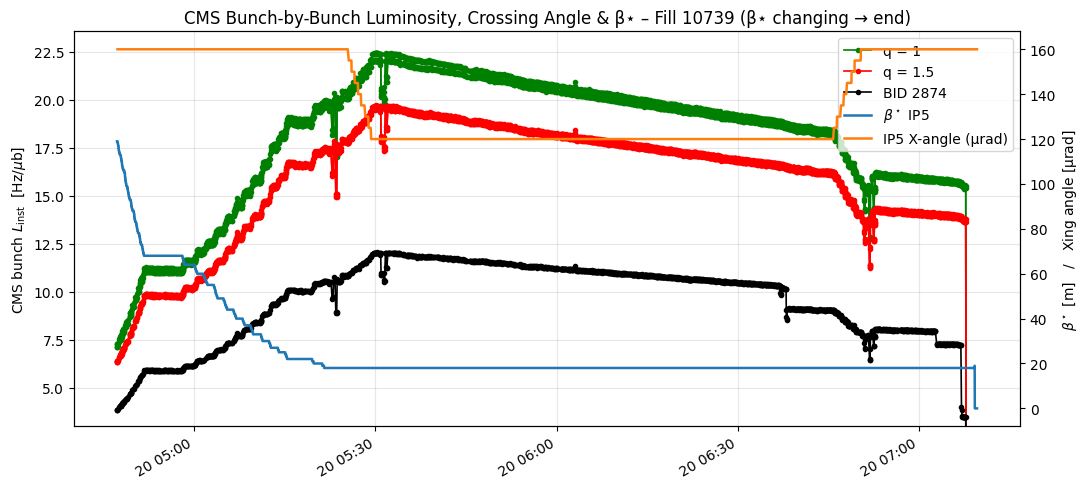

In [7]:
# --- Detect β⋆ change for CMS ---
tol_cms        = 1e-4
day0_cms       = df_beta_cms.index[0].floor("D")
t_threshold_cms = day0_cms + pd.Timedelta(hours=4)
beta_series_cms = df_beta_cms[BETASTAR_PV]

baseline_cms   = beta_series_cms.loc[:t_threshold_cms].iloc[-1]
after_4h_cms   = beta_series_cms.loc[t_threshold_cms:]
t_change_cms   = after_4h_cms[(after_4h_cms - baseline_cms).abs() > tol_cms].index[0]
print("CMS: β⋆ starts changing (after 04:00) at:", t_change_cms)

# --- Plotting Function for CMS ---
def plot_window_cms(t_start_cms, t_stop_cms, title_suffix_cms, dynamic_ylim_cms=False):
    sl_cms       = df_cms.loc[t_start_cms:t_stop_cms]
    sl_beta_cms  = df_beta_cms.loc[t_start_cms:t_stop_cms]
    sl_xing_cms  = df_xing_cms.loc[t_start_cms:t_stop_cms]

    fig_cms, ax_lumi_cms = plt.subplots(figsize=(11, 5))

    # Left axis – CMS bunches
    for lbl_cms, (bids_cms, colour_cms) in BUNCH_GROUPS_CMS.items():
        sl_cms[[f"B{b}" for b in bids_cms]].plot(
            ax      = ax_lumi_cms,
            color   = colour_cms,
            lw      = 1.2,
            marker  = ".",
            legend  = False
        )
    ax_lumi_cms.plot(
        sl_cms.index,
        sl_cms[f"B{SOLO_BID_CMS}"],
        color   = "black",
        lw      = 1.2,
        marker  = ".",
        label   = "_nolegend_"
    )

    ax_lumi_cms.set_ylabel(r"CMS bunch $L_{\rm inst}$  [Hz/$\mu$b]")
    if dynamic_ylim_cms:
        y_max_cms = sl_cms.max().max()
        ax_lumi_cms.set_ylim(3, y_max_cms * 1.05)
    else:
        ax_lumi_cms.set_ylim(3, 9.5)

    ax_lumi_cms.set_title(
        f"CMS Bunch-by-Bunch Luminosity, Crossing Angle & β⋆ – Fill 10739 ({title_suffix_cms})"
    )
    ax_lumi_cms.grid(alpha=0.3)

    # Right axis – β⋆ and crossing angle at IP5
    ax_r_cms = ax_lumi_cms.twinx()
    sl_beta_cms[BETASTAR_PV].plot(
        ax    = ax_r_cms,
        color = "tab:blue",
        lw    = 1.8,
        label = r"$\beta^\star$ IP5"
    )
    sl_xing_cms[XING_PV].plot(
        ax    = ax_r_cms,
        color = "tab:orange",
        lw    = 1.8,
        label = r"IP5 X-angle (µrad)"
    )
    ax_r_cms.set_ylabel(r"$\beta^\star$ [m]   /   Xing angle [µrad]")

    # Combined legend
    handles_cms = [
        Line2D([0], [0], color="green",  marker=".", lw=1.2, label="q = 1"),
        Line2D([0], [0], color="red",    marker=".", lw=1.2, label="q = 1.5"),
        Line2D([0], [0], color="black",  marker=".", lw=1.2, label=f"BID {SOLO_BID_CMS}"),
        ax_r_cms.lines[0],
        ax_r_cms.lines[1],
    ]
    ax_lumi_cms.legend(handles=handles_cms, loc="upper right")
    plt.tight_layout()
    return fig_cms

# --- Draw CMS panels ---
fig_before_cms = plot_window_cms(
    df_cms.index.min(),
    t_change_cms,
    "β⋆ flat → first change (>04:00)"
)
fig_after_cms = plot_window_cms(
    t_change_cms,
    df_cms.index.max(),
    "β⋆ changing → end",
    dynamic_ylim_cms=True
)

plt.show()


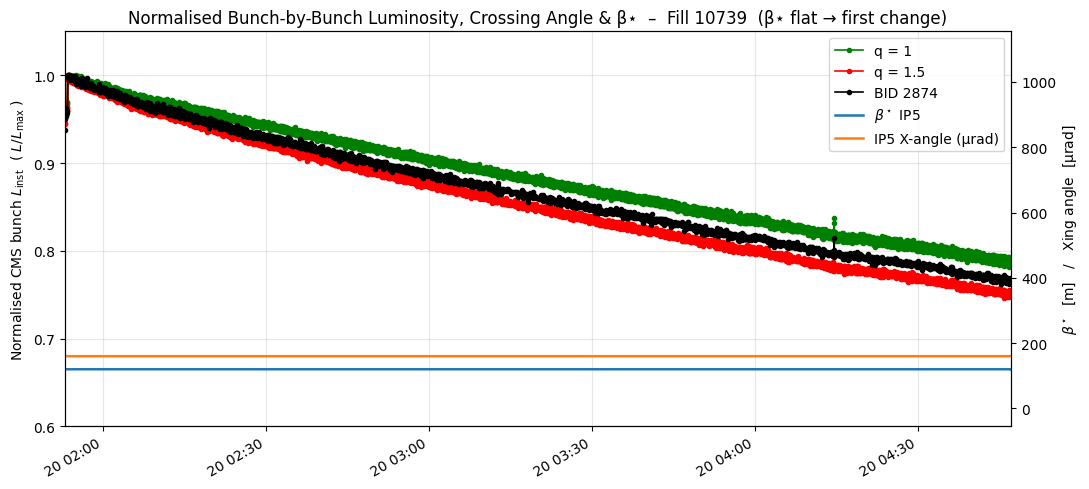

In [8]:
# 1) slice the data to the “before β⋆-change” period for CMS
df_first_cms     = df_cms.loc[df_cms.index.min() : t_change_cms]
beta_first_cms   = df_beta_cms.loc[df_beta_cms.index.min() : t_change_cms]
xing_first_cms   = df_xing_cms.loc[df_xing_cms.index.min() : t_change_cms]

# 2) per-bunch maxima in that window
max_vals_cms     = df_first_cms.max()        # one value per column “B###”

# 3) normalise every CMS bunch curve by its own maximum
df_norm_cms      = df_first_cms.div(max_vals_cms)

# 4) plot – same style as original, now for CMS
fig_norm_cms, ax_lum_cms = plt.subplots(figsize=(11, 5))

for lbl_cms, (bids_cms, colour_cms) in BUNCH_GROUPS_CMS.items():
    df_norm_cms[[f"B{b}" for b in bids_cms]].plot(
        ax     = ax_lum_cms,
        color  = colour_cms,
        lw     = 1.2,
        marker = ".",
        legend = False
    )

# solo CMS bunch
ax_lum_cms.plot(
    df_norm_cms.index,
    df_norm_cms[f"B{SOLO_BID_CMS}"],
    color  = "black",
    lw     = 1.2,
    marker = ".",
    label  = "_nolegend_"
)

# Axis labels and title
ax_lum_cms.set_ylabel(
    "Normalised CMS bunch $L_{\\rm inst}$  ( $L/L_{\\max}$ )"
)
ax_lum_cms.set_ylim(0.6, 1.05)
ax_lum_cms.set_title(
    "Normalised Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  "
    "(β⋆ flat → first change)"
)
ax_lum_cms.grid(alpha=0.3)

# Right axis – β⋆ and crossing angle at IP5
ax_r_cms = ax_lum_cms.twinx()
beta_first_cms[BETASTAR_PV].plot(
    ax    = ax_r_cms,
    color = "tab:blue",
    lw    = 1.8,
    label = r"$\beta^\star$ IP5"
)
xing_first_cms[XING_PV].plot(
    ax    = ax_r_cms,
    color = "tab:orange",
    lw    = 1.8,
    label = r"IP5 X-angle (µrad)"
)
ax_r_cms.set_ylabel(r"$\beta^\star$  [m]   /   Xing angle  [µrad]")

# Legend
handles_cms = [
    Line2D([0], [0], color="green",  marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",    marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black",  marker=".", lw=1.2, label=f"BID {SOLO_BID_CMS}"),
    ax_r_cms.lines[0],
    ax_r_cms.lines[1],
]

# X-axis zoom (optional)
start_time_cms = df_first_cms.index[0].replace(hour=1, minute=53, second=0)
ax_lum_cms.set_xlim([start_time_cms, t_change_cms])

ax_lum_cms.legend(handles=handles_cms, loc="upper right")
plt.tight_layout()
plt.show()


/tmp/ipykernel_3521770/1297259188.py:13: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  {col: cumtrapz(df_norm_cms[col].values, t_sec_cms, initial=0.0)


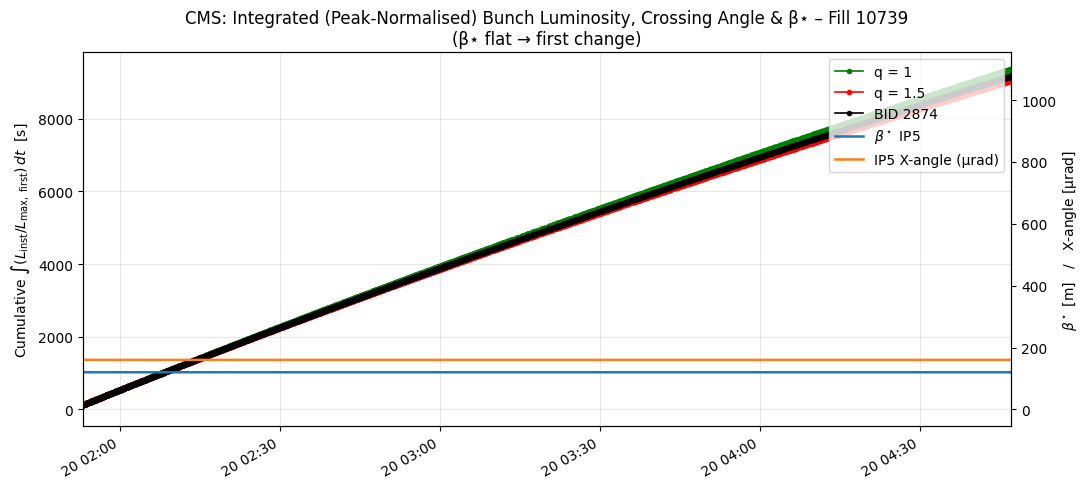

In [9]:
# A) Slice data before β⋆ changes for CMS
df_first_cms     = df_cms.loc[df_cms.index.min() : t_change_cms]
beta_first_cms   = df_beta_cms.loc[df_beta_cms.index.min() : t_change_cms]
xing_first_cms   = df_xing_cms.loc[df_xing_cms.index.min() : t_change_cms]

# B) Normalise each CMS bunch by its own maximum in that window
max_vals_first_cms = df_first_cms.max()
df_norm_cms        = df_first_cms.div(max_vals_first_cms)

# C) Compute cumulative integral (in seconds, dimensionless y)
t_sec_cms = (df_norm_cms.index - df_norm_cms.index[0]).total_seconds()
df_cum_norm_cms = pd.DataFrame(
    {col: cumtrapz(df_norm_cms[col].values, t_sec_cms, initial=0.0)
     for col in df_norm_cms.columns},
    index=df_norm_cms.index
)

# D) Plotting
fig_cms, ax_l_cms = plt.subplots(figsize=(11, 5))

# Left axis – cumulative ∫(L / L_peak) dt
for lbl_cms, (bids_cms, colour_cms) in BUNCH_GROUPS_CMS.items():
    df_cum_norm_cms[[f"B{b}" for b in bids_cms]].plot(
        ax     = ax_l_cms,
        color  = colour_cms,
        lw     = 1.2,
        marker = ".",
        legend = False
    )

# Solo CMS bunch
ax_l_cms.plot(
    df_cum_norm_cms.index,
    df_cum_norm_cms[f"B{SOLO_BID_CMS}"],
    color   = "black",
    lw      = 1.2,
    marker  = ".",
    label   = "_nolegend_"
)

ax_l_cms.set_ylabel(
    r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm first}})\,dt$  [s]"
)
ax_l_cms.set_title(
    "CMS: Integrated (Peak-Normalised) Bunch Luminosity, Crossing Angle & β⋆ – Fill 10739\n"
    "(β⋆ flat → first change)"
)
ax_l_cms.grid(alpha=0.3)

# Right axis – β⋆ and crossing angle at IP5
ax_r_cms = ax_l_cms.twinx()
beta_first_cms[BETASTAR_PV].plot(
    ax    = ax_r_cms,
    color = "tab:blue",
    lw    = 1.8,
    label = r"$\beta^\star$ IP5"
)
xing_first_cms[XING_PV].plot(
    ax    = ax_r_cms,
    color = "tab:orange",
    lw    = 1.8,
    label = r"IP5 X-angle (µrad)"
)
ax_r_cms.set_ylabel(r"$\beta^\star$ [m]   /   X-angle [µrad]")

# Combined legend
handles_cms = [
    Line2D([0], [0], color="green",  marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",    marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black",  marker=".", lw=1.2, label=f"BID {SOLO_BID_CMS}"),
    ax_r_cms.lines[0],
    ax_r_cms.lines[1],
]
ax_l_cms.legend(handles=handles_cms, loc="upper right")

# Optional x-axis zoom (same as other plots)
start_time_cms = df_norm_cms.index[0].replace(hour=1, minute=53, second=0)
ax_l_cms.set_xlim([start_time_cms, t_change_cms])

plt.tight_layout()
plt.show()


In [10]:
# Final values at the moment of β⋆ change for CMS
final_values_norm_cms = df_cum_norm_cms.iloc[-1]   # units: seconds

print("CMS: Peak-normalised cumulative luminosity delivered up to β⋆ change:\n")
print(final_values_norm_cms.to_string(float_format="%.3e"))

# %-difference functions
def sym_pct_diff(a, b):
    """Symmetric % difference between a and b."""
    return 100 * (b - a) / ((a + b) / 2)

def rel_pct_diff(ref, comp):
    """Relative % difference of comp vs. ref."""
    return 100 * (comp - ref) / ref

# --- Individual bunch comparisons ---
L20_cms,  L500_cms  = final_values_norm_cms["B20"], final_values_norm_cms["B500"]
rel_20_500_cms = rel_pct_diff(L20_cms, L500_cms)
sym_20_500_cms = sym_pct_diff(L20_cms, L500_cms)

L1250_cms, L1800_cms = final_values_norm_cms["B1250"], final_values_norm_cms["B1800"]
rel_1250_1800_cms = rel_pct_diff(L1250_cms, L1800_cms)
sym_1250_1800_cms = sym_pct_diff(L1250_cms, L1800_cms)

print("\nCMS: Peak-normalised cumulative luminosity up to β⋆ change (seconds):\n")
print(f"  B20   : {L20_cms  : .3e} s")
print(f"  B500  : {L500_cms : .3e} s")
print(f"    →  relative % diff (ref B20):   {rel_20_500_cms :6.4f} %")
print(f"    →  symmetric % diff:            {sym_20_500_cms :6.4f} %\n")

print(f"  B1250 : {L1250_cms: .3e} s")
print(f"  B1800 : {L1800_cms: .3e} s")
print(f"    →  relative % diff (ref B1250): {rel_1250_1800_cms :6.4f} %")
print(f"    →  symmetric % diff:            {sym_1250_1800_cms :6.4f} %")

# --- Group (sum-based) comparison ---
group_q1_cms   = ["B20", "B500"]
group_q15_cms  = ["B1250", "B1800"]

tot_q1_cms  = final_values_norm_cms[group_q1_cms].sum()
tot_q15_cms = final_values_norm_cms[group_q15_cms].sum()

sym_tot_cms = sym_pct_diff(tot_q1_cms, tot_q15_cms)
rel_tot_cms = rel_pct_diff(tot_q1_cms, tot_q15_cms)

print("\nCMS: Group SUM of peak-normalised cumulative luminosity at β⋆ change:")
print(f"  q = 1 total (B20 + B500):      {tot_q1_cms  : .3e} s")
print(f"  q = 1.5 total (B1250 + B1800): {tot_q15_cms : .3e} s")
print(f"  Symmetric % difference:        {sym_tot_cms:.3f} %")
print(f"  Relative % difference (ref q=1): {rel_tot_cms:.3f} %")

# --- Group (mean-based) comparison ---
mean_q1_cms  = final_values_norm_cms[group_q1_cms].mean()
mean_q15_cms = final_values_norm_cms[group_q15_cms].mean()

sym_mean_cms = sym_pct_diff(mean_q1_cms, mean_q15_cms)
rel_mean_cms = rel_pct_diff(mean_q1_cms, mean_q15_cms)

print("\nCMS: Group MEAN of peak-normalised cumulative luminosity at β⋆ change:")
print(f"  q = 1 mean (B20 & B500):       {mean_q1_cms  : .3e} s")
print(f"  q = 1.5 mean (B1250 & B1800):  {mean_q15_cms : .3e} s")
print(f"  Symmetric % difference:        {sym_mean_cms:.3f} %")
print(f"  Relative % difference (ref q=1): {rel_mean_cms:.3f} %")


CMS: Peak-normalised cumulative luminosity delivered up to β⋆ change:

B20     9.369e+03
B500    9.338e+03
B1250   9.073e+03
B1800   9.049e+03
B2874   9.177e+03

CMS: Peak-normalised cumulative luminosity up to β⋆ change (seconds):

  B20   :  9.369e+03 s
  B500  :  9.338e+03 s
    →  relative % diff (ref B20):   -0.3321 %
    →  symmetric % diff:            -0.3326 %

  B1250 :  9.073e+03 s
  B1800 :  9.049e+03 s
    →  relative % diff (ref B1250): -0.2637 %
    →  symmetric % diff:            -0.2641 %

CMS: Group SUM of peak-normalised cumulative luminosity at β⋆ change:
  q = 1 total (B20 + B500):       1.871e+04 s
  q = 1.5 total (B1250 + B1800):  1.812e+04 s
  Symmetric % difference:        -3.170 %
  Relative % difference (ref q=1): -3.121 %

CMS: Group MEAN of peak-normalised cumulative luminosity at β⋆ change:
  q = 1 mean (B20 & B500):        9.353e+03 s
  q = 1.5 mean (B1250 & B1800):   9.061e+03 s
  Symmetric % difference:        -3.170 %
  Relative % difference (ref q=1): 

### overall

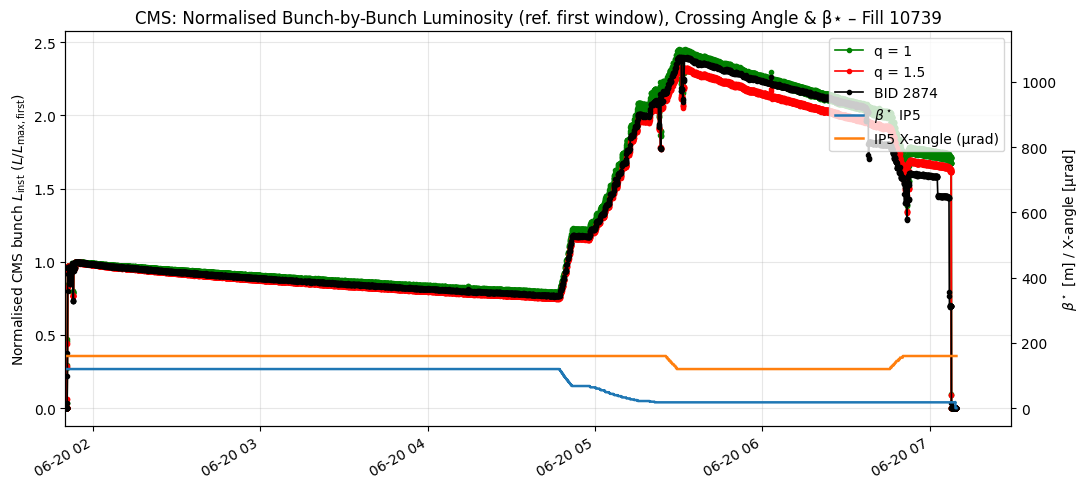

In [11]:
# ─────────────────────────────────────────────────────────────────────
# CMS: Normalise the *entire fill* to the first-window peak of each bunch
# ─────────────────────────────────────────────────────────────────────

# 1) reference maxima from the first split (β⋆ flat → t_change_cms)
max_first_cms = df_cms.loc[t0_cms:t_change_cms].max()

# 2) normalise the *entire* df_cms by those maxima
df_norm_all_cms = df_cms.div(max_first_cms)

# 3) plot – CMS-specific
pad_cms    = 0.05  # 5% head- & foot-room
ymin_cms   = df_norm_all_cms.min().min()
ymax_cms   = df_norm_all_cms.max().max()
yrange_cms = ymax_cms - ymin_cms
ylow_cms   = ymin_cms - pad_cms * yrange_cms
yhigh_cms  = ymax_cms + pad_cms * yrange_cms

fig_cms, ax_l_cms = plt.subplots(figsize=(11, 5))

# Left axis – normalised CMS bunch curves
for lbl_cms, (bids_cms, colour_cms) in BUNCH_GROUPS_CMS.items():
    df_norm_all_cms[[f"B{b}" for b in bids_cms]].plot(
        ax      = ax_l_cms,
        color   = colour_cms,
        lw      = 1.2,
        marker  = ".",
        legend  = False
    )

# Solo CMS bunch
ax_l_cms.plot(
    df_norm_all_cms.index,
    df_norm_all_cms[f"B{SOLO_BID_CMS}"],
    color   = "black",
    lw      = 1.2,
    marker  = ".",
    label   = "_nolegend_"
)

ax_l_cms.set_ylabel(
    r"Normalised CMS bunch $L_{\rm inst}$ ($L/L_{\max,\mathrm{first}}$)"
)
ax_l_cms.set_ylim(ylow_cms, yhigh_cms)
ax_l_cms.set_title(
    "CMS: Normalised Bunch-by-Bunch Luminosity (ref. first window), "
    "Crossing Angle & β⋆ – Fill 10739"
)
ax_l_cms.grid(alpha=0.3)

# Right axis – β⋆ and crossing angle at IP5
ax_r_cms = ax_l_cms.twinx()
df_beta_cms[BETASTAR_PV].plot(
    ax      = ax_r_cms,
    color   = "tab:blue",
    lw      = 1.8,
    label   = r"$\beta^\star$ IP5"
)
df_xing_cms[XING_PV].plot(
    ax      = ax_r_cms,
    color   = "tab:orange",
    lw      = 1.8,
    label   = r"IP5 X-angle (µrad)"
)
ax_r_cms.set_ylabel(r"$\beta^\star$ [m] / X-angle [µrad]")

# Combined legend
handles_cms = [
    Line2D([0], [0], color="green",  marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",    marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black",  marker=".", lw=1.2, label=f"BID {SOLO_BID_CMS}"),
    ax_r_cms.lines[0],  # β⋆
    ax_r_cms.lines[1],  # X-angle
]
ax_l_cms.legend(handles=handles_cms, loc="upper right")

# Optional x-range zoom
ax_l_cms.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()


/tmp/ipykernel_3521770/1761121103.py:4: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  {col: cumtrapz(df_norm_all_cms[col].values, t_sec_all_cms, initial=0.0)


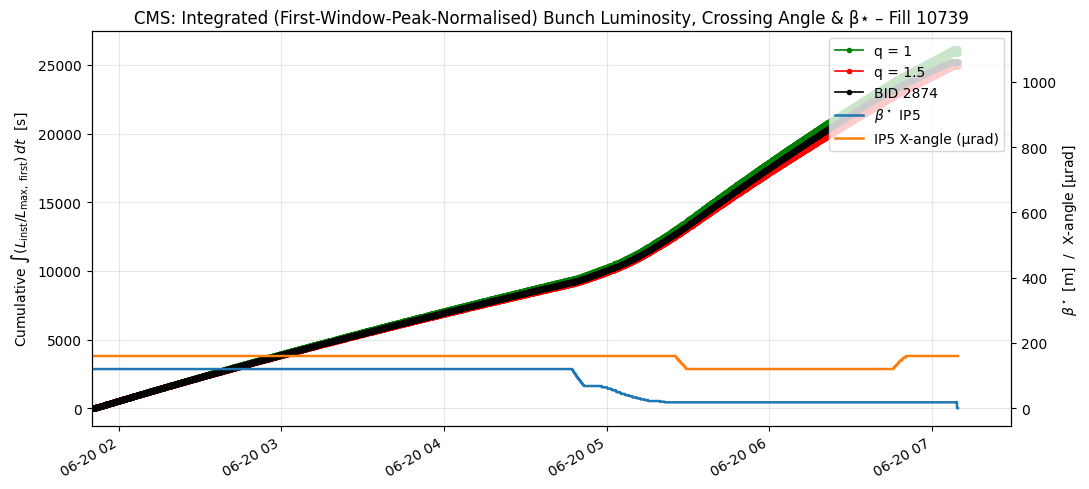

In [12]:
# 1) cumulative integral for each CMS bunch
t_sec_all_cms = (df_norm_all_cms.index - df_norm_all_cms.index[0]).total_seconds()
df_cum_all_cms = pd.DataFrame(
    {col: cumtrapz(df_norm_all_cms[col].values, t_sec_all_cms, initial=0.0)
     for col in df_norm_all_cms.columns},
    index=df_norm_all_cms.index
)

# 2) dynamic y-range with 5% padding
pad_cms       = 0.05
ymin_cms      = df_cum_all_cms.min().min()
ymax_cms      = df_cum_all_cms.max().max()
yrange_cms    = ymax_cms - ymin_cms
ylow_cms      = ymin_cms - pad_cms * yrange_cms
yhigh_cms     = ymax_cms + pad_cms * yrange_cms

# 3) plot
fig_int_cms, ax_l_cms = plt.subplots(figsize=(11, 5))

# left axis – cumulative ∫(L / L_max,first) dt for CMS groups
for lbl_cms, (bids_cms, colour_cms) in BUNCH_GROUPS_CMS.items():
    df_cum_all_cms[[f"B{b}" for b in bids_cms]].plot(
        ax      = ax_l_cms,
        color   = colour_cms,
        lw      = 1.2,
        marker  = ".",
        legend  = False
    )

# solo CMS bunch
ax_l_cms.plot(
    df_cum_all_cms.index,
    df_cum_all_cms[f"B{SOLO_BID_CMS}"],
    color   = "black",
    lw      = 1.2,
    marker  = ".",
    label   = f"BID {SOLO_BID_CMS}"
)

ax_l_cms.set_ylabel(
    r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm first}})\,dt$  [s]"
)
ax_l_cms.set_ylim(ylow_cms, yhigh_cms)
ax_l_cms.set_title(
    "CMS: Integrated (First-Window-Peak-Normalised) Bunch Luminosity, "
    "Crossing Angle & β⋆ – Fill 10739"
)
ax_l_cms.grid(alpha=0.3)

# right axis – β⋆ and X-angle at IP5 for CMS
ax_r_cms = ax_l_cms.twinx()
df_beta_cms[BETASTAR_PV].plot(
    ax      = ax_r_cms,
    color   = "tab:blue",
    lw      = 1.8,
    label   = r"$\beta^\star$ IP5"
)
df_xing_cms[XING_PV].plot(
    ax      = ax_r_cms,
    color   = "tab:orange",
    lw      = 1.8,
    label   = r"IP5 X-angle (µrad)"
)
ax_r_cms.set_ylabel(r"$\beta^\star$ [m]  /  X-angle [µrad]")

# combined legend
handles_cms = [
    Line2D([0], [0], color="green",  marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",    marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black",  marker=".", lw=1.2, label=f"BID {SOLO_BID_CMS}"),
    ax_r_cms.lines[0],
    ax_r_cms.lines[1],
]
ax_l_cms.legend(handles=handles_cms, loc="upper right")

# x-range zoom
ax_l_cms.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()


In [13]:
# ─────────────────────────────────────────────────────────────────────
# CMS: Peak-normalised cumulative luminosity over the entire fill
# ─────────────────────────────────────────────────────────────────────

# 1) Extract the final cumulative values (in seconds)
final_vals_cms = df_cum_all_cms.iloc[-1]

print("CMS: Peak-normalised cumulative luminosity delivered over the whole fill:\n")
print(final_vals_cms.to_string(float_format="%.3e"))

# 2) Define %-difference functions
def sym_pct_diff(a, b):
    """Symmetric % difference between a and b."""
    return 100 * (b - a) / ((a + b) / 2)

def rel_pct_diff(ref, comp):
    """Relative % difference of comp vs. ref."""
    return 100 * (comp - ref) / ref

# 3) Individual bunch comparisons
L20_cms, L500_cms   = final_vals_cms["B20"],  final_vals_cms["B500"]
rel_20_500_cms      = rel_pct_diff(L20_cms, L500_cms)
sym_20_500_cms      = sym_pct_diff(L20_cms, L500_cms)

L1250_cms, L1800_cms = final_vals_cms["B1250"], final_vals_cms["B1800"]
rel_1250_1800_cms   = rel_pct_diff(L1250_cms, L1800_cms)
sym_1250_1800_cms   = sym_pct_diff(L1250_cms, L1800_cms)

print("\nCMS: Peak-normalised cumulative luminosity over the whole fill (seconds):\n")
print(f"  B20   : {L20_cms   : .3e} s")
print(f"  B500  : {L500_cms : .3e} s")
print(f"    →  relative % diff (ref B20):   {rel_20_500_cms:6.4f} %")
print(f"    →  symmetric % diff:            {sym_20_500_cms:6.4f} %\n")
print(f"  B1250 : {L1250_cms: .3e} s")
print(f"  B1800 : {L1800_cms: .3e} s")
print(f"    →  relative % diff (ref B1250): {rel_1250_1800_cms:6.4f} %")
print(f"    →  symmetric % diff:            {sym_1250_1800_cms:6.4f} %")

# 4) Group comparisons (sum-based)
group_q1_cms   = ["B20", "B500"]
group_q15_cms  = ["B1250", "B1800"]

tot_q1_cms  = final_vals_cms[group_q1_cms].sum()
tot_q15_cms = final_vals_cms[group_q15_cms].sum()

rel_tot_cms = rel_pct_diff(tot_q1_cms, tot_q15_cms)
sym_tot_cms = sym_pct_diff(tot_q1_cms, tot_q15_cms)

print("\nCMS: Group SUM of peak-normalised cumulative luminosity at β⋆ change:")
print(f"  q = 1 total (B20 + B500):      {tot_q1_cms  : .3e} s")
print(f"  q = 1.5 total (B1250 + B1800): {tot_q15_cms : .3e} s")
print(f"  Symmetric % difference:        {sym_tot_cms:.3f} %")
print(f"  Relative  % difference (ref q=1): {rel_tot_cms:.3f} %")

# 5) Group comparisons (mean-based)
mean_q1_cms  = final_vals_cms[group_q1_cms].mean()
mean_q15_cms = final_vals_cms[group_q15_cms].mean()

sym_mean_cms = sym_pct_diff(mean_q1_cms, mean_q15_cms)
rel_mean_cms = rel_pct_diff(mean_q1_cms, mean_q15_cms)

print("\nCMS: Group MEAN of peak-normalised cumulative luminosity at β⋆ change:")
print(f"  q = 1 mean (B20 & B500):       {mean_q1_cms  : .3e} s")
print(f"  q = 1.5 mean (B1250 & B1800):  {mean_q15_cms : .3e} s")
print(f"  Symmetric % difference:        {sym_mean_cms:.3f} %")
print(f"  Relative  % difference (ref q=1): {rel_mean_cms:.3f} %")


CMS: Peak-normalised cumulative luminosity delivered over the whole fill:

B20     2.614e+04
B500    2.588e+04
B1250   2.499e+04
B1800   2.490e+04
B2874   2.524e+04

CMS: Peak-normalised cumulative luminosity over the whole fill (seconds):

  B20   :  2.614e+04 s
  B500  :  2.588e+04 s
    →  relative % diff (ref B20):   -1.0045 %
    →  symmetric % diff:            -1.0096 %

  B1250 :  2.499e+04 s
  B1800 :  2.490e+04 s
    →  relative % diff (ref B1250): -0.3858 %
    →  symmetric % diff:            -0.3865 %

CMS: Group SUM of peak-normalised cumulative luminosity at β⋆ change:
  q = 1 total (B20 + B500):       5.202e+04 s
  q = 1.5 total (B1250 + B1800):  4.989e+04 s
  Symmetric % difference:        -4.178 %
  Relative  % difference (ref q=1): -4.093 %

CMS: Group MEAN of peak-normalised cumulative luminosity at β⋆ change:
  q = 1 mean (B20 & B500):        2.601e+04 s
  q = 1.5 mean (B1250 & B1800):   2.494e+04 s
  Symmetric % difference:        -4.178 %
  Relative  % difference (